# Дисперсионный анализ

---

**Дисперсионный анализ** является наиболее общим методом сравнения средних. В дисперсионном анализе можно исследовать зависимость количественных признаков (зависимых переменных) от одного или нескольких качественных признаков (факторов).

В качестве зависимых переменных выбраны переменные study_hours_week и final_exam_score, а в качестве категориальных – teaching_quality и gender.

Ниже представлена таблица статистических эффектов, являющихся последствиями разбиения выборки на группы. Для выделенных красным цветом эффектов можно утверждать, что при разбиении на группы по данному эффекту наверняка будут группы со статистически значимыми отличиями средних.

In [1]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA

df = pd.read_csv("../data/student_perfomance_sample.csv")

maov = MANOVA.from_formula("study_hours_week + final_exam_score ~ teaching_quality * gender", data=df)
res = maov.mv_test()
effects = ["Intercept", "teaching_quality", "gender", "teaching_quality:gender"]
rows = []
for eff in effects:
    sub = res.results[eff]["stat"]
    wilks = sub.loc["Wilks' lambda", "Value"]
    Fval  = sub.loc["Wilks' lambda", "F Value"]
    pval  = sub.loc["Wilks' lambda", "Pr > F"]
    rows.append([eff, wilks, Fval, pval])

manova_table = pd.DataFrame(rows, columns=["Эффект", "Лямбда Уилкса", "F", "p-значение"])
manova_table.style.apply(lambda row: ['color: red; font-weight: bold' * len(row) if row["p-значение"] < 0.05 else '' for _ in manova_table.columns], axis=1)

,Эффект,Лямбда Уилкса,F,p-значение
0,Intercept,0.019875,23104.232671,0.000000
1,teaching_quality,0.994832,1.215299,0.302235
2,gender,0.998083,0.899923,0.406952
3,teaching_quality:gender,0.998116,0.441924,0.778367


В представленной ниже таблице расположены значения средних зависимых переменных study_hours_week и final_exam_score и другими статистиками в группах, соответствующих трем уровням категориального предиктора teaching_quality – Low, Medium, High.

In [2]:
import numpy as np
from scipy.stats import t

def ci_95(series):
    series = series.dropna()
    n = len(series)
    mean = series.mean()
    se = series.std(ddof=1) / np.sqrt(n)
    t_crit = t.ppf(0.975, df=n-1)
    lower = mean - t_crit * se
    upper = mean + t_crit * se
    return mean, lower, upper, n

rows = []
for level, group in df.groupby("teaching_quality"):
    m1, low1, high1, n_obs = ci_95(group["study_hours_week"])
    m2, low2, high2, _ = ci_95(group["final_exam_score"])
    rows.append([level, m1, low1, high1, m2, low2, high2, n_obs])

result_table = pd.DataFrame(
    rows,
    columns=[
        "Качество преподавания",
        "Часы учебы/нед среднее", "Часы учебы/нед -95,00%", "Часы учебы/нед +95,00%",
        "Итоговый балл среднее", "Итоговый балл -95,00%", "Итоговый балл +95,00%",
        "N"
    ]
)
result_table

,Качество преподавания,Часы учебы/нед среднее,"Часы учебы/нед -95,00%","Часы учебы/нед +95,00%",Итоговый балл среднее,"Итоговый балл -95,00%","Итоговый балл +95,00%",N
0,High,19.802768,19.113621,20.491915,67.321799,66.905746,67.737853,289
1,Low,20.406593,19.324898,21.488289,66.296703,65.624730,66.968677,91
2,Medium,20.127660,19.619743,20.635577,67.283688,66.960164,67.607212,564


На рисунках ниже представлены графики средних для переменных study_hours_week и final_exam_score.

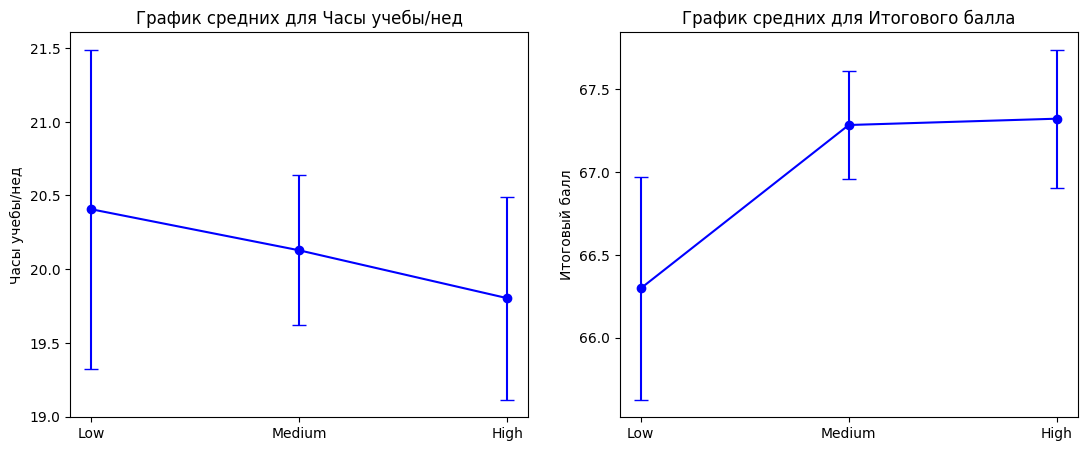

In [3]:
import matplotlib.pyplot as plt

order = ["Low", "Medium", "High"]
plot_df = result_table.set_index("Качество преподавания").loc[order]

means1 = plot_df["Часы учебы/нед среднее"]
lower1 = plot_df["Часы учебы/нед -95,00%"]
upper1 = plot_df["Часы учебы/нед +95,00%"]

means2 = plot_df["Итоговый балл среднее"]
lower2 = plot_df["Итоговый балл -95,00%"]
upper2 = plot_df["Итоговый балл +95,00%"]

x = np.arange(len(order))
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)
ax = axes[0]
ax.errorbar(x, means1, yerr=[means1 - lower1, upper1 - means1], fmt='o-', color='blue', capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_title("График средних для Часы учебы/нед")
ax.set_ylabel("Часы учебы/нед")
ax = axes[1]
ax.errorbar(x, means2, yerr=[means2 - lower2, upper2 - means2], fmt='o-', color='blue', capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_title("График средних для Итогового балла")
ax.set_ylabel("Итоговый балл")
plt.show()

Из графиков и таблицы видно, что среднее количество часов, потраченных в неделю на учебу у учащихся школ с низким качеством преподавания превосходит количество часов со средним качеством преподавания и еще больше превосходит с высоким. С итоговым баллом наоборот: средний итоговый балл у учащихся с низким качеством преподавания ниже, чем у учащихся со средним и высоким качеством преподавания.

*Первый полученный результат* объясняется тем, что учащиеся вынуждены больше времени тратить на самостоятельное изучение материала, чтобы компенсировать недостатки обучения.

*Второй полученный результат* вполне логичен: высокое преподавание позволяет ученикам лучше понять и усвоить материал, что приводит к лучшим результатам на экзамене.

Ниже представлен НЗР тест для переменных Часы учебы/нед и Итоговый балл. Для первой переменной верна гипотеза о равенстве средних, для второй средний итоговый балл группы Low статистически значимо меньше среднего итогового балла группы Medium и High.

In [4]:
from scipy.stats import ttest_ind

order = ["Low", "Medium", "High"]
def lsd_matrix(df, var):
    groups = {g: df[df["teaching_quality"] == g][var].dropna() for g in order}
    means = {g: groups[g].mean() for g in order}
    mat = pd.DataFrame(index=order, columns=order, dtype=float)
    for i in order:
        for j in order:
            if i == j:
                mat.loc[i, j] = np.NaN
            else:
                _, p = ttest_ind(groups[i], groups[j], equal_var=True)
                mat.loc[i, j] = p

    col_labels = [f"{k + 1} (среднее = {means[order[k]]:.2f})" for k in range(len(order))]
    mat.columns = col_labels
    mat.index = order
    return mat

lsd_study = lsd_matrix(df, "study_hours_week")
lsd_final = lsd_matrix(df, "final_exam_score")
display(lsd_study.style.apply(lambda row: ['color: red; font-weight: bold' if row[col] < 0.05 else '' for col in lsd_study.columns], axis=1))
display(lsd_final.style.apply(lambda row: ['color: red; font-weight: bold' if row[col] < 0.05 else '' for col in lsd_final.columns], axis=1))

,1 (среднее = 20.41),2 (среднее = 20.13),3 (среднее = 19.80)
Low,nan,0.681803,0.385416
Medium,0.681803,nan,0.460157
High,0.385416,0.460157,nan


,1 (среднее = 66.30),2 (среднее = 67.28),3 (среднее = 67.32)
Low,nan,0.022669,0.015570
Medium,0.022669,nan,0.889969
High,0.015570,0.889969,nan


Ниже представлен тест Левена, результаты которого свидетельствуют об однородности дисперсий.

In [5]:
from scipy.stats import levene

def levene_table(df, dv, group):
    groups = [g[dv].dropna().values for name, g in df.groupby(group)]
    F, p = levene(*groups, center='mean')
    result = pd.DataFrame({"F": [F], "p": [p]}) 
    return result

display(levene_table(df, "study_hours_week", "teaching_quality"))
display(levene_table(df, "final_exam_score", "teaching_quality"))

,F,p
0,2.371353,0.093912


,F,p
0,1.352847,0.259005


Теперь исследуем влияние второй группирующей переменной на *Итоговый балл*.

На рисунке ниже изображен график средних с двумя взаимодействующими факторами для Итогового балла.

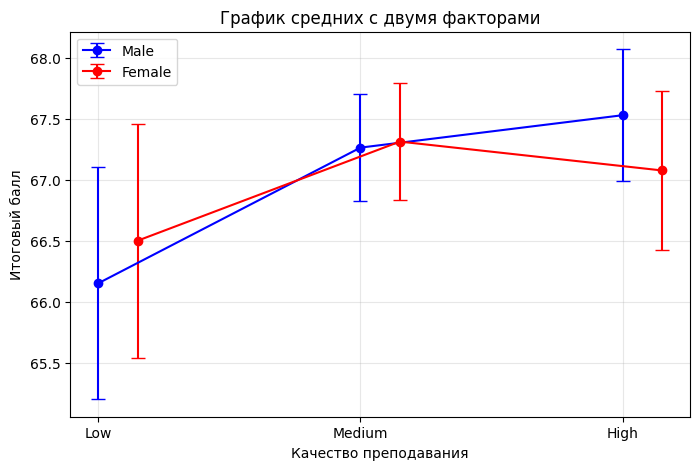

In [6]:
def ci_95(series):
    series = series.dropna()
    n = len(series)
    mean = series.mean()
    se = series.std(ddof=1) / np.sqrt(n)
    t_crit = t.ppf(0.975, df=n-1)
    lower = mean - t_crit * se
    upper = mean + t_crit * se
    return mean, lower, upper

order = ["Low", "Medium", "High"]
rows = []
for gender in ["Male", "Female"]:
    for level in order:
        subset = df[(df["teaching_quality"] == level) & (df["gender"] == gender)]
        m, low, high = ci_95(subset["final_exam_score"])
        rows.append([gender, level, m, low, high])

stats_df = pd.DataFrame(rows, columns=["gender", "teaching_quality", "mean", "lower", "upper"])
x = np.arange(len(order))
offset = 0.15
male = stats_df[stats_df["gender"] == "Male"]
female = stats_df[stats_df["gender"] == "Female"]

plt.figure(figsize=(8, 5))
plt.errorbar(x, male["mean"], yerr=[male["mean"] - male["lower"], male["upper"] - male["mean"]], fmt='o-', color="blue", capsize=5, label="Male")
plt.errorbar(x + offset, female["mean"], yerr=[female["mean"] - female["lower"], female["upper"] - female["mean"]], fmt='o-', color="red", capsize=5, label="Female")
plt.xticks(x, order)
plt.xlabel("Качество преподавания")
plt.ylabel("Итоговый балл")
plt.title("График средних с двумя факторами")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

По рисунку видно, что у учащихся мужского пола с высоким качеством преподавания и у учащихся мужского пола с низким качеством преподавания итоговый балл соответственно больше и меньше, чем во всех остальных группах. Также итоговый балл у учащихся мужского пола выше, чем у женского, только при высоком качестве преподавания.

Ниже представлен НЗР тест для *Итогового балла*.

In [7]:
order = [("Low", "Male"), ("Low", "Female"), ("Medium", "Male"), ("Medium", "Female"), ("High", "Male"), ("High", "Female")]
groups = []
labels = []
for tq, g in order:
    grp = df[(df["teaching_quality"] == tq) & (df["gender"] == g)]["final_exam_score"].dropna()
    groups.append(grp)
    labels.append(f"{tq}, {g}")

means = [grp.mean() for grp in groups]
col_labels = [f"{i+1} (среднее = {means[i]:.2f})" for i in range(len(groups))]
k = len(groups)
p_matrix = pd.DataFrame(np.nan, index=labels, columns=col_labels)
for i in range(k):
    for j in range(i+1, k):
        t_res = ttest_ind(groups[i], groups[j], equal_var=False)
        p = t_res.pvalue
        p_matrix.iloc[i, j] = p
        p_matrix.iloc[j, i] = p 
        
def highlight_pvals(val):
    if pd.isna(val):
        return ""
    return "color: red; font-weight: bold" if val < 0.05 else ""

styled = p_matrix.style.map(highlight_pvals)
styled

,1 (среднее = 66.15),2 (среднее = 66.50),3 (среднее = 67.26),4 (среднее = 67.31),5 (среднее = 67.53),6 (среднее = 67.08)
"Low, Male",nan,0.603721,0.036956,0.032078,0.013611,0.111775
"Low, Female",0.603721,nan,0.150795,0.132502,0.064657,0.321114
"Medium, Male",0.036956,0.150795,nan,0.881432,0.452597,0.637797
"Medium, Female",0.032078,0.132502,0.881432,nan,0.554833,0.563335
"High, Male",0.013611,0.064657,0.452597,0.554833,nan,0.290671
"High, Female",0.111775,0.321114,0.637797,0.563335,0.290671,nan


Видно, что для группы (Low, Male) средний итоговый балл статистически значимо отличается от среднего итогового балла групп 3,4 и 5. Следовательно первый вывод оказывается статистически значимым, второй – нет.

Ниже представлен тест Левена, результаты которого свидетельствуют об однородности дисперсий.

In [8]:
order = [("Low", "Male"), ("Low", "Female"), ("Medium", "Male"), ("Medium", "Female"), ("High", "Male"),("High", "Female")] 
groups = []
for tq, g in order:
    grp = df[(df["teaching_quality"] == tq) & (df["gender"] == g)]["final_exam_score"].dropna()
    groups.append(grp)

F, p = levene(*groups, center='mean')
result = pd.DataFrame({"F": [F], "p": [p]})
result

,F,p
0,1.694637,0.133183


На рисунках ниже представлены гистограммы частот для всех групп переменных Итоговый балл и Часы учебы/нед соответственно.

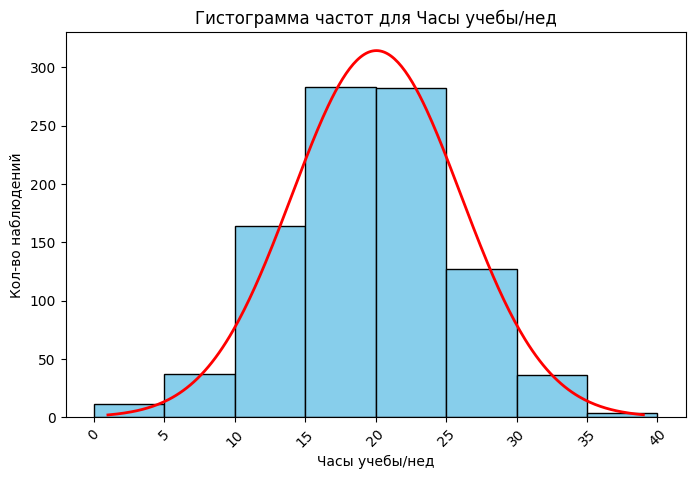

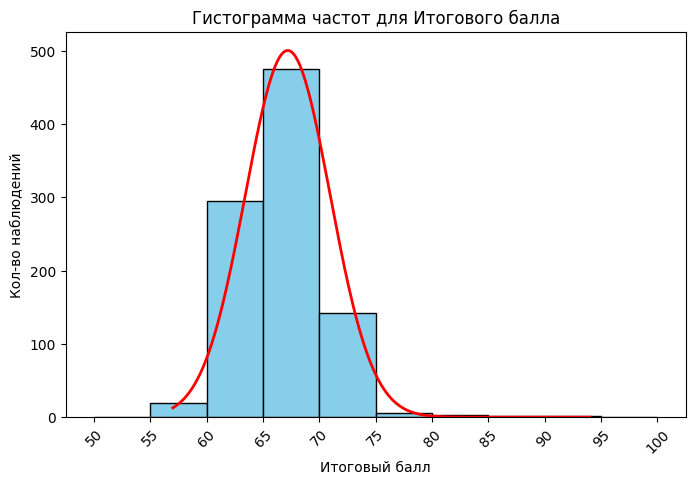

In [9]:
from scipy.stats import norm

def plot_hist_with_normal(df, column, bins, xlabel, title):
    data = df[column].dropna()
    mu, sigma = norm.fit(data)
    x = np.linspace(min(data), max(data), 300)
    pdf = norm.pdf(x, mu, sigma)
    count = pd.cut(data, bins=bins, right=True, include_lowest=True).value_counts().sort_index()
    
    plt.figure(figsize=(8, 5))
    plt.bar(bins[:-1], count.values, width=bins[1] - bins[0], align="edge", edgecolor="black", color="skyblue")
    plt.plot(x, len(data) * (bins[1] - bins[0]) * pdf, linewidth=2, color="red")
    plt.xticks(bins, rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel("Кол-во наблюдений")
    plt.title(title)
    plt.show()

plot_hist_with_normal(df=df, column="study_hours_week", bins=np.arange(0, 45, 5), xlabel="Часы учебы/нед", title="Гистограмма частот для Часы учебы/нед")
plot_hist_with_normal(df=df, column="final_exam_score", bins=np.arange(50, 105, 5), xlabel="Итоговый балл", title="Гистограмма частот для Итогового балла")

Эти рисунки демонстрируют относительное соответствие рассматриваемых величин нормально распределенным.

На рисунках ниже представлены графики средних и стандартных отклонений для Итогового балла и Часы учебы/нед (эффект Качество преп).

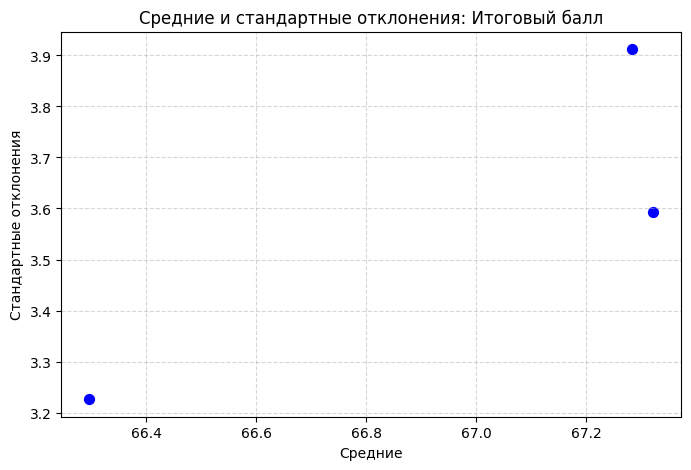

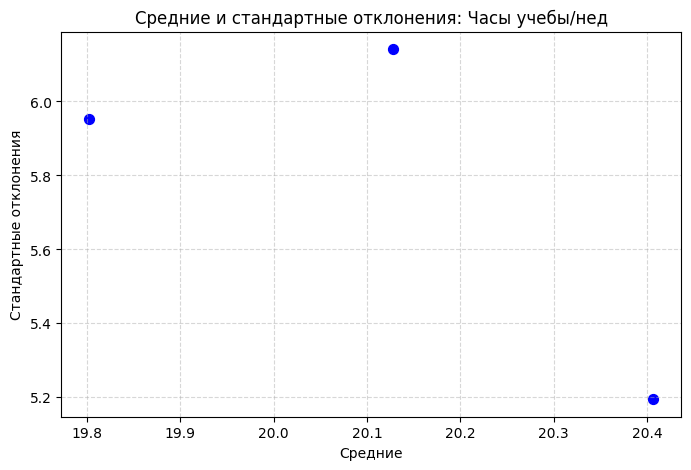

In [10]:
def plot_mean_sd(df, group_col, value_col, title):
    summary = (df.groupby(group_col)[value_col].agg(['mean', 'std']).reindex(["Low", "Medium", "High"]))
    x = summary['mean'].values
    y = summary['std'].values
    labels = summary.index.tolist()
    plt.figure(figsize=(8,5))
    plt.scatter(x, y, color="blue", s=50)
    plt.xlabel("Средние")
    plt.ylabel("Стандартные отклонения")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_mean_sd(df, group_col="teaching_quality", value_col="final_exam_score", title="Средние и стандартные отклонения: Итоговый балл")
plot_mean_sd(df, group_col="teaching_quality", value_col="study_hours_week", title="Средние и стандартные отклонения: Часы учебы/нед")

Из этих рисунков видно, что средние и стандартные отклонения коррелируют незначительно. Таким образом, основные условия применимости дисперсионного анализа выполнены, что подтверждает достоверность результатов.